<a href="https://colab.research.google.com/github/Azimoj/Home-Credit-Default-Risk/blob/main/Model_Optimization_on_fs90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import gc
import time
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold

**Spliting**

In [3]:
data_clean = pd.read_csv('/content/drive/MyDrive/p7/data/data_clean.csv')

In [4]:
df= pd.read_csv('/content/drive/MyDrive/p7/data/data_feature_importances.csv')

In [ ]:
data_clean.head()

In [6]:
data_clean.shape

(307505, 561)

In [5]:
df.shape

(559, 2)

In [10]:
df1= data_clean.drop('SK_ID_CURR', axis=1)


In [11]:
X = df1.drop('TARGET',axis=1)
y= df1['TARGET']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X ,y,test_size = 0.3,random_state=0)
print('The shape of X_train is', X_train.shape)
print('The shape of X_test is', X_test.shape)
print('The shape of y_train is', y_train.shape)
print('The shape of y_test is', y_test.shape)

The shape of X_train is (215253, 559)
The shape of X_test is (92252, 559)
The shape of y_train is (215253,)
The shape of y_test is (92252,)


In [16]:
del X,y,df1

In [12]:
df2= df.head(245)

In [13]:
# remove all the columns which are not in app_train
filter_columns = list(df2.feature)

def remove_columns(dataframe, filter_columns):
    """dataframe : dataframe to filter
    filter_columns : columns to keep"""
    new = pd.DataFrame()

    for column in filter_columns:
        try:
            new[column] = dataframe[column]
        except:
            print('...colonne non présente : ', column)
            print('\n')
    print("All selected columns have been kept from the dataset")
    return new

In [18]:
X_train_reduced = remove_columns(X_train, filter_columns)
X_test_reduced = remove_columns(X_test, filter_columns)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # This is added back by InteractiveShellApp.init_path()


All selected columns have been kept from the dataset
All selected columns have been kept from the dataset


In [25]:
from sklearn.preprocessing import StandardScaler
# StandardScaler
scaler_std = StandardScaler()

# Jeu d'entraînement du jeu d'entraînement
X_train_std = scaler_std.fit_transform(X_train_reduced.copy(deep=True))
# Jeu de validation du jeu d'entraînement
X_test_std = scaler_std.transform(X_test_reduced.copy(deep=True))


### **Bayesian Optimization**

Bayesian optimization uses probability to find the minimum of a function. The final aim is to find the input value to a function which can gives us the lowest possible output value.It usually performs better than random,grid and manual search providing better performance in the testing phase and reduced optimization time. In Hyperopt, Bayesian Optimization can be implemented giving 3 three main parameters to the function fmin.

* Objective Function = defines the loss function to minimize.
* Domain Space = defines the range of input values to test (in Bayesian Optimization this space creates a probability distribution for each of the used Hyperparameters).
* Optimization Algorithm = defines the search algorithm to use to select the best input values to use in each new iteration.

https://github.com/krishnaik06/All-Hyperparamter-Optimization/blob/master/Hyper%20Parameter%20Optimization.ipynb

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from time import time

In [20]:
! pip install bayesian_optimization

In [21]:
from bayes_opt import BayesianOptimization

In [81]:
# Définition de l'objective fonction
def lgbm_eval_1(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                learning_rate, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'goss',
#         'learning_rate' : 0.005,
#         'n_estimators' : 10000,
        'n_jobs' : -1,
#         'class_weight' : 'balanced', # Balanced   
        'learning_rate' : learning_rate,     
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : 0
    }
    
    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True,
                                    random_state=42)
    
    cv_preds = np.zeros(X_train_reduced.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train_std,
                                                         y_train):

        x_tr = X_train_reduced.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train_reduced.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='auc', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict_proba(x_cv,
                                   num_iteration=lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(y_train, cv_preds)

In [82]:
lgbm_bayesian_opt_1 = \
    BayesianOptimization(lgbm_eval_1,
                         {'learning_rate' : (0.1, 0.5),
                          'num_leaves' : (25, 50),
                          'max_depth' : (8, 15),
                          'min_split_gain' : (0, 0.3),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.1, 1),
                          
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)})

bayesian_opt_1 = lgbm_bayesian_opt_1.maximize(n_iter=20, init_points=4)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7457   |  0.6318   |  0.2333   |  14.02    |  19.05    |  65.92    |  0.01714  |  36.96    |  0.2258   |  0.3      |  0.4284   |
|  2        |  0.7491   |  0.729    |  0.1718   |  10.07    |  44.57    |  57.35    |  0.2402   |  26.01    |  0.1368   |  0.1157   |  0.952    |
|  3        |  0.7412   |  0.5239   |  0.3654   |  11.6     |  48.41    |  45.59    |  0.04859  |  27.08    |  0.02416  |  0.1865   |  0.8673   |
|  4        |  0.7449   |  0.8523   |  0.2666   |  10.97    |  21.61    |  21.1     |  0.1166   |  29.17    |  0.2173   |  0.1336   |  0.7335   |
|  5        |  0.7394   |  0.9483   |  0.3758   |  13.48    |  72.3     |  51.82    |  0.08273  |  32.9     |  0.2934   |  0

In [83]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_1.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 0.8711809165619055, 'learning_rate': 0.12767676405299283, 'max_depth': 14.12514737388938, 'min_child_samples': 22.39921892112339, 'min_child_weight': 74.07752830677325, 'min_split_gain': 0.29626789884311583, 'num_leaves': 30.628662870355416, 'reg_alpha': 0.0023705629883609717, 'reg_lambda': 0.29983644378576485, 'subsample': 0.13195809926602853}


**Sans le paramètre class_weight='balanced'**

In [84]:
param_lgbm_bayesian_opt_1 = {'objective' : 'binary',
                             'boosting_type' : 'goss',
                             'n_jobs' : -1,
                             'colsample_bytree': 0.87,
                             'max_depth': 14,
                             'min_child_samples': 22,
                             'min_child_weight': 74,
                             'min_split_gain': 0.3,
                             'num_leaves': 30,
                             'reg_alpha': 0.002,
                             'reg_lambda': 0.3,
                             'subsample': 0.13,
                             'learning_rate' : 0.13,
                             'verbosity' : -1,
                             'seed' : 0}

In [85]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_1 = LGBMClassifier(**param_lgbm_bayesian_opt_1,
                                     #class_weight='balanced',
                                     force_col_wise=True)

In [86]:
lgbm_bayesian_opt_1.fit(X_train_reduced, y_train)

LGBMClassifier(boosting_type='goss', colsample_bytree=0.87, force_col_wise=True,
               learning_rate=0.13, max_depth=14, min_child_samples=22,
               min_child_weight=74, min_split_gain=0.3, num_leaves=30,
               objective='binary', reg_alpha=0.002, reg_lambda=0.3, seed=0,
               subsample=0.13, verbosity=-1)

In [87]:
prediction2= lgbm_bayesian_opt_1.predict(X_test_reduced)

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print(confusion_matrix(y_test,prediction2))
print("------------------")
print('Accuracy Score: ', accuracy_score(y_test,prediction2))
print("------------------")
print(classification_report(y_test,prediction2))
acc = accuracy_score(y_test,prediction2)

[[84748   128]
 [ 7253   123]]
------------------
Accuracy Score:  0.9199908945063522
------------------
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84876
         1.0       0.49      0.02      0.03      7376

    accuracy                           0.92     92252
   macro avg       0.71      0.51      0.50     92252
weighted avg       0.89      0.92      0.88     92252



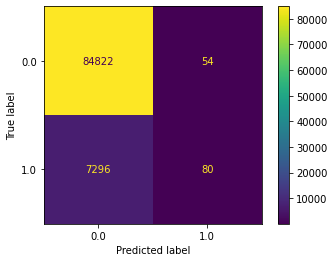

In [72]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lgbm_bayesian_opt_1, X_test_reduced, y_test)  

In [89]:
AUROC_LGBM_=roc_auc_score(y_test, prediction2)
AUROC_LGBM_

0.507583811305077

**Avec le paramètre class_weight='balanced'**

In [90]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_1_bal = LGBMClassifier(**param_lgbm_bayesian_opt_1,
                                         class_weight='balanced',
                                         force_col_wise=True)

In [91]:
lgbm_bayesian_opt_1_bal.fit(X_train_reduced, y_train)

LGBMClassifier(boosting_type='goss', class_weight='balanced',
               colsample_bytree=0.87, force_col_wise=True, learning_rate=0.13,
               max_depth=14, min_child_samples=22, min_child_weight=74,
               min_split_gain=0.3, num_leaves=30, objective='binary',
               reg_alpha=0.002, reg_lambda=0.3, seed=0, subsample=0.13,
               verbosity=-1)

In [94]:
prediction_opt_1= lgbm_bayesian_opt_1_bal.predict(X_test_reduced)

In [98]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print(confusion_matrix(y_test,prediction_opt_1))
print("------------------")
print('Accuracy Score: ', accuracy_score(y_test,prediction_opt_1))
print("------------------")
print(classification_report(y_test,prediction_opt_1))
acc_opt_1 = accuracy_score(y_test,prediction_opt_1)

[[61209 23667]
 [ 2559  4817]]
------------------
Accuracy Score:  0.7157134804665481
------------------
              precision    recall  f1-score   support

         0.0       0.96      0.72      0.82     84876
         1.0       0.17      0.65      0.27      7376

    accuracy                           0.72     92252
   macro avg       0.56      0.69      0.55     92252
weighted avg       0.90      0.72      0.78     92252



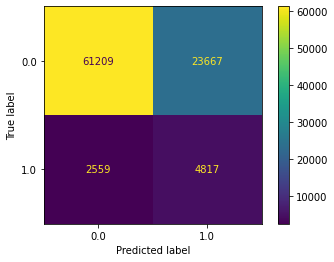

In [96]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lgbm_bayesian_opt_1_bal, X_test_reduced, y_test) 

In [99]:
AUROC_opt_1 =roc_auc_score(y_test, prediction_opt_1)
AUROC_opt_1

0.6871109579124182

In [111]:
import pickle

pickle.dump(lgbm_bayesian_opt_1_bal, open('drive/MyDrive/p7/lgbm_bayesian_opt_1_bal.sav', 'wb'))

In [100]:
#https://www.youtube.com/watch?v=CV9FTCvQ32Q&t=637s
out = lgbm_bayesian_opt_1_bal.predict_proba(X_test_reduced)

LGBM prediction for sample 160 = [0.48880093 0.51119907]
Actual outcome =  1.0


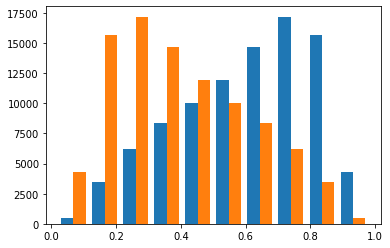

In [110]:
plt.hist(out)
num= 160
print('LGBM prediction for sample', num, '=', out[num])
print('Actual outcome = ', y_train.iloc[num])

In [112]:
! pip install shap

In [113]:
# Interprétation
import shap
shap.initjs()

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


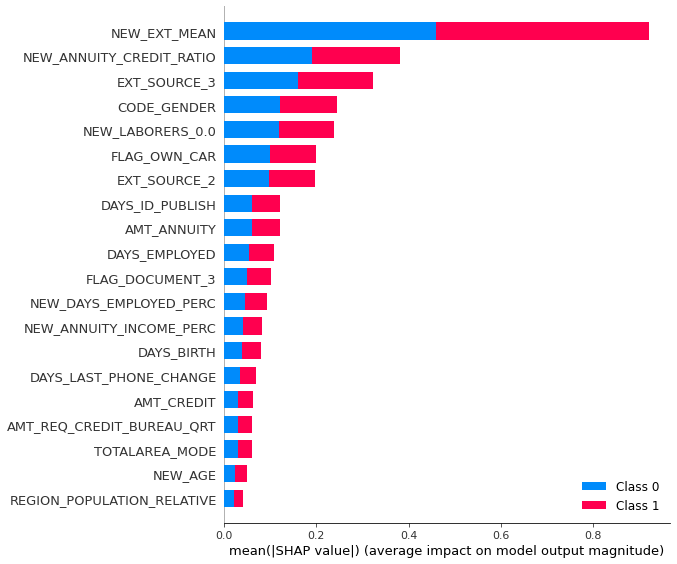

In [114]:
# TreeExplainer - This explainer is used for models that are based on a tree-like decision tree, random forest, gradient boosting.
explainer = shap.TreeExplainer(lgbm_bayesian_opt_1_bal)
shap_values = explainer.shap_values(X_test_reduced)
# Summary plot
shap.summary_plot(shap_values, X_test_reduced)

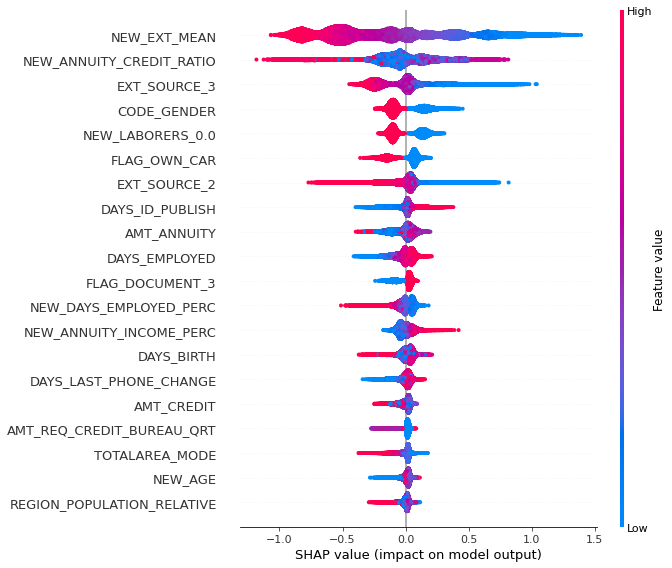

In [115]:
shap.summary_plot(shap_values[1], X_test_reduced, show=False)

In [123]:
explainer = shap.Explainer(lgbm_bayesian_opt_1_bal, X_train_reduced)
shap_values = explainer(X_train_reduced, check_additivity=False)

100%|===================| 215094/215253 [15:27<00:00]       

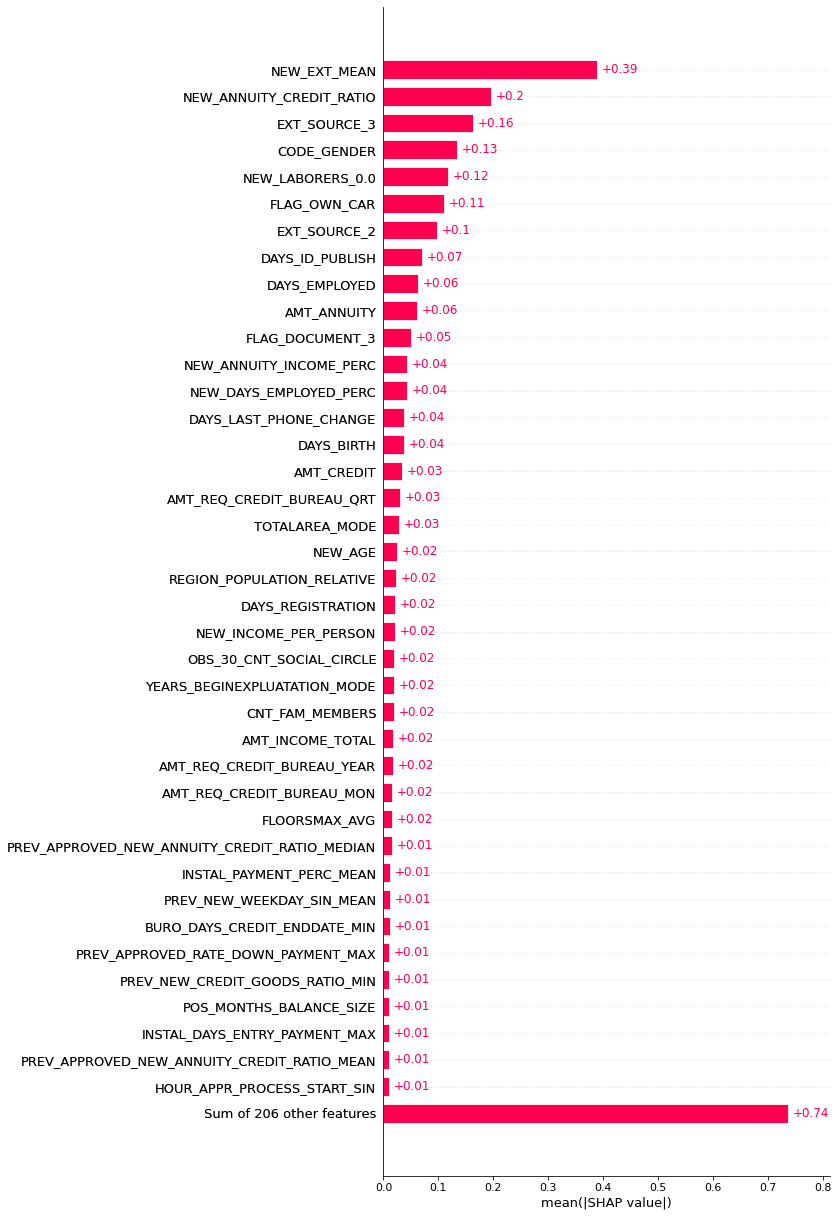

In [124]:
shap.plots.bar(shap_values, max_display=40)

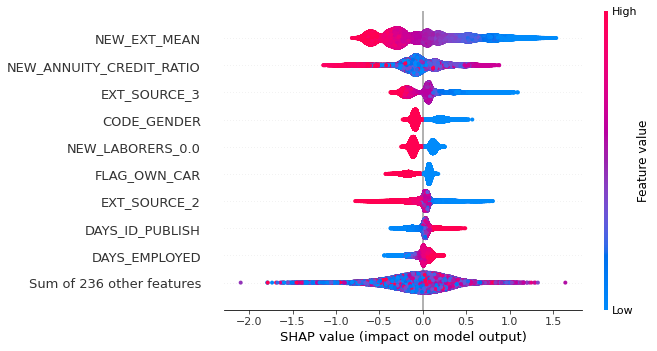

In [125]:
shap.plots.beeswarm(shap_values)